<h1><span style="color: #5D3FD3;"> Objective 1: Image Classifier using CNN</span></h1>

<br>

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Muhammad Fitri Amir bin Abdullah|DAAA/FT/2B/06|2222811|


<br>

In this task, I aim to implement an image classifier using a Convolutional Neural Network in order to classify a dataset that contains 15 different types of vegetables. There are some steps given that I will need to adhere to such as: 
- converting the image into grayscale (1 channel instead of 3)
- making 2 model for 2 inputs, 31x31 pixels and 128x128 pixels, NOT 224 (the original pixels given in the dataset).

Looking at the metadata of the dataset given, here's some useful information:
- Total 15 Classes of 3000 images; means that this is a multi-class classification task.
- Each class contain 200 images
- Size of each image is 224*224 and images are in *.jpg format.

<hr>

In [23]:
!pip install --quiet keras-tuner numpy tqdm wandb pandas tensorflow-addons graphviz matplotlib seaborn plotly scikit-learn

In [24]:
pip install --quiet tensorflow

Note: you may need to restart the kernel to use updated packages.


## 1. Importing Packages + Utility Functions

In [25]:
import numpy as np
import pandas as pd
import datetime
import os, time, math, datetime, warnings, pytz, glob, PIL
import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import plotly as px
import plotly.graph_objects as go
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model
from functools import reduce, wraps
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, SGD

custom  = {"axes.edgecolor" : "white", 
            "grid.linestyle": "dashed",
            "grid.color": "gray"
            }
sns.set_style("whitegrid", rc = custom)

### 1a) Checking that GPU is used

In [26]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12166659686777264695
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5819596800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9212904932173933900
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [27]:
!nvidia-smi

Sun Nov 19 22:57:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P2              23W / 130W |   2372MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
pip install --quiet opencv-python

Note: you may need to restart the kernel to use updated packages.


### Utility Functions

In [29]:
def read_pic(dataset_path, filename):
    images = []
    labels = []
    folder_path = os.path.join(dataset_path, filename)
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))
            image = image.astype('float32')
            images.append(image)
            labels.append(label)
    #         images = np.array(images)
    #         labels = np.array(labels)
    return images, labels

In [30]:
from sklearn.preprocessing import LabelEncoder
def preprocess(train, test, val):

    # unpack data
    X_train, y_train = train
    X_test, y_test = test
    X_val, y_val = val

    # normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    X_val = X_val / 255.0

    # Reshape the data (assuming 128x128 images)
    input_shape = (128, 128, 1)  # Adjust based on your image size and channels
    X_train = X_train.reshape(X_train.shape[0], *input_shape)
    X_test = X_test.reshape(X_test.shape[0], *input_shape)
    X_val = X_val.reshape(X_val.shape[0], *input_shape)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.transform(y_val)

    # one hot encode labels
    y_train = to_categorical(y_train, num_classes = len(np.unique(y_train)))
    y_test = to_categorical(y_test, num_classes= len(np.unique(y_test)))
    y_val = to_categorical(y_val, num_classes= len(np.unique(y_val)))

    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


In [45]:
def plot_lc(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Cross Entropy Loss', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend()

    ax[1].plot(acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [46]:
def get_loss_acc(models):
    
    losses = {}
    accuracies = {}
    
    for model in models:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0, epochs=100, batch_size=128)
        losses[model.name] = history.history['val_loss']
        accuracies[model.name] = history.history['val_accuracy']
        
    loss_df = pd.DataFrame(losses)  
    acc_df = pd.DataFrame(accuracies)
    
    return loss_df, acc_df

## 2. Exploratory Data Analysis

### 2a. Importing dataset and preparing test/train set

In [31]:
dataset_path = "Datasets/Dataset for CA1 part A/"

# Load training images and labels
train_images, train_labels = read_pic(dataset_path, "train")
X_train = np.array(train_images)
y_train = np.array(train_labels)

# Load test images and labels
test_images, test_labels = read_pic(dataset_path, "test")
X_test = np.array(test_images)
y_test = np.array(test_labels)

val_images, val_labels = read_pic(dataset_path, "validation")
X_val = np.array(val_images)
y_val = np.array(val_labels)

### 2b. Checking the dataset for errors and outliers

In this portion I will be checking:
- All pixels >=0 and <=255
- No missing values for any pixels
- Total number of classes
- Names of classes
- Class distribution
- Blank images

<h5>Checking Pixel values</h5>

In [32]:
print(f"Min pixel value in x_train: {np.amin(X_train)}")
print(f"Max pixel value in x_train: {np.amax(X_train)}")
print(f"Min pixel value in x_test: {np.amin(X_test)}")
print(f"Max pixel value in x_test: {np.amax(X_test)}")

Min pixel value in x_train: 0.0
Max pixel value in x_train: 255.0
Min pixel value in x_test: 0.0
Max pixel value in x_test: 255.0


<h5>Checking for missing values</h5>

In [33]:
print(f"Any missing values in x_train: {np.isnan(X_train).any()}")
print(f"Any missing values in x_test: {np.isnan(X_test).any()}")

Any missing values in x_train: False
Any missing values in x_test: False


<h5>Checking all the classes</h5>

In [34]:
print(f"Classes in y_train: {len(np.unique(y_train))}")
print(f"Names of classes: {np.unique(y_train)}")

Classes in y_train: 15
Names of classes: ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


<h5>Ensuring that pictures are grayscale</h5>

In [35]:
print(X_train[0].shape)

(128, 128)


<h5>Sample Images</h5>

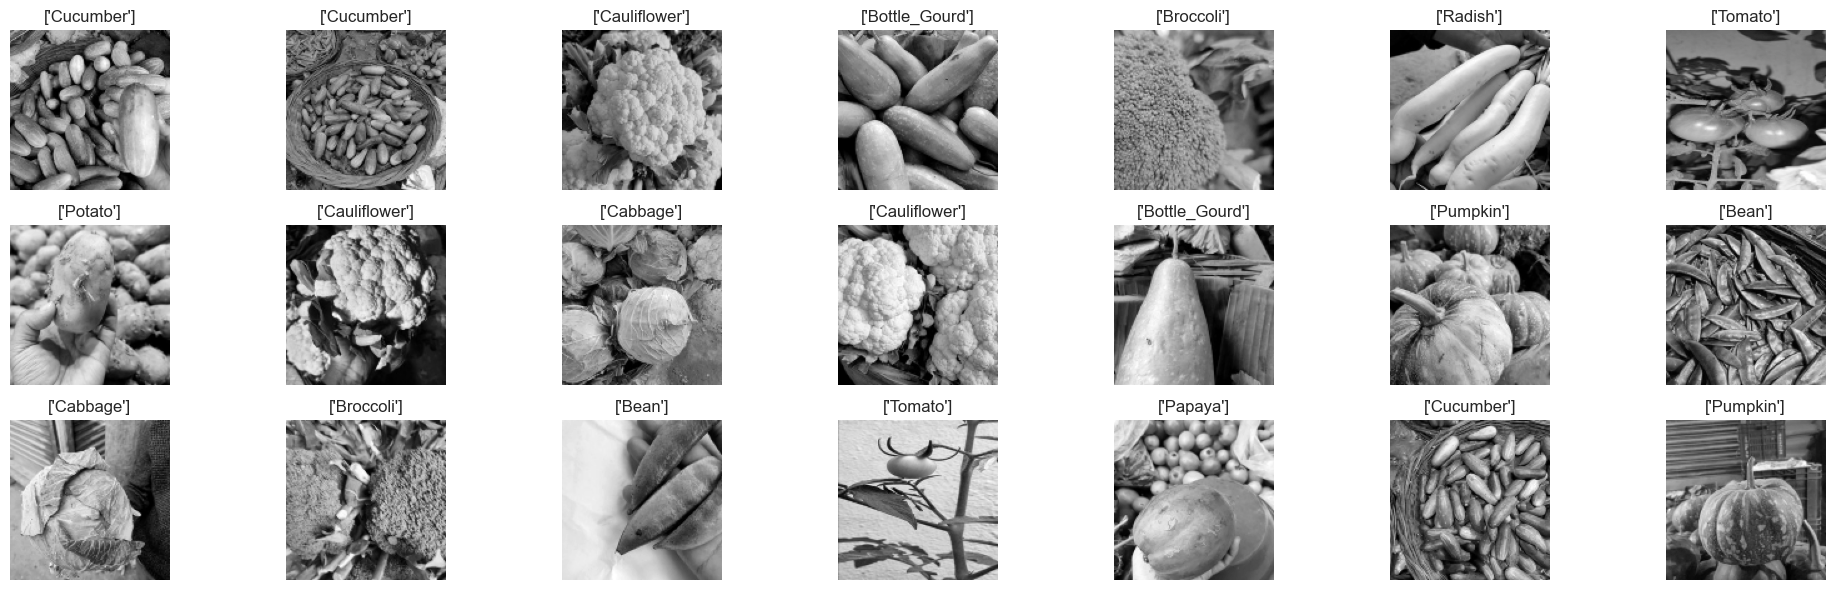

In [36]:
#Checking if the data was imported correctly

fig = plt.figure(figsize=(20, 6))
for i in range(1, 22):
    randn = int(np.random.random() * len(X_train))
    ax = fig.add_subplot(3, 7, i)
    ax.imshow(X_train[randn], cmap='gray')  # Use cmap='gray' to display grayscale images
    ax.set_title([y_train.flatten()[randn]])
    ax.axis('off')

plt.tight_layout()
plt.show()


Label Bean makes up 8.64% of the training data
Label Bitter_Gourd makes up 7.98% of the training data
Label Bottle_Gourd makes up 4.88% of the training data
Label Brinjal makes up 9.61% of the training data
Label Broccoli makes up 8.31% of the training data
Label Cabbage makes up 5.57% of the training data
Label Capsicum makes up 3.89% of the training data
Label Carrot makes up 2.84% of the training data
Label Cauliflower makes up 6.50% of the training data
Label Cucumber makes up 8.99% of the training data
Label Papaya makes up 6.27% of the training data
Label Potato makes up 4.18% of the training data
Label Pumpkin makes up 9.02% of the training data
Label Radish makes up 2.75% of the training data
Label Tomato makes up 10.58% of the training data


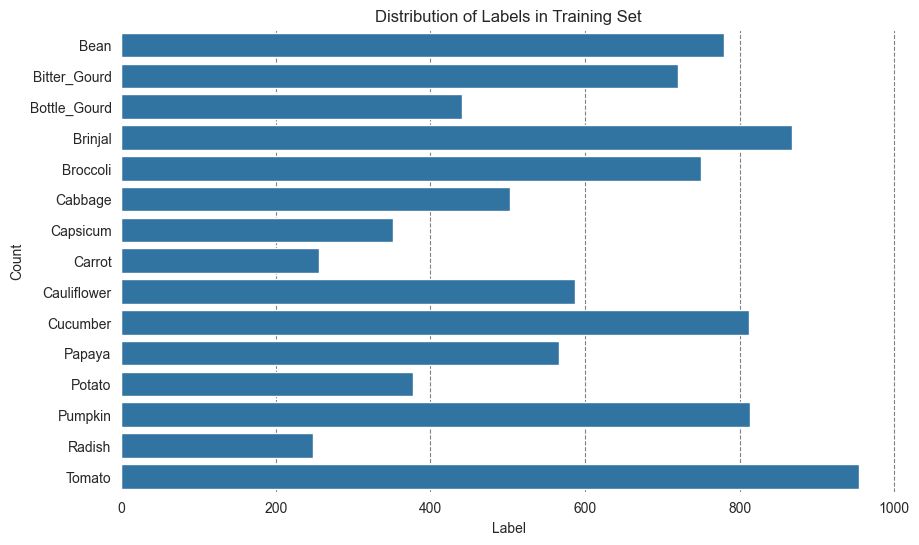

In [37]:
labels = np.unique(y_train)
# print(labels)
# map labels to their names
# y_train_label = np.array([labels[i] for i in y_train])

for label in labels:
    #Count percentage of each label
    percentage = (np.sum(y_train == label) / y_train.shape[0]) * 100
    print(f"Label {label} makes up {percentage:.2f}% of the training data")

#use seaborn plot percentage
plt.figure(figsize=(10, 6))
sns.countplot(y_train)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

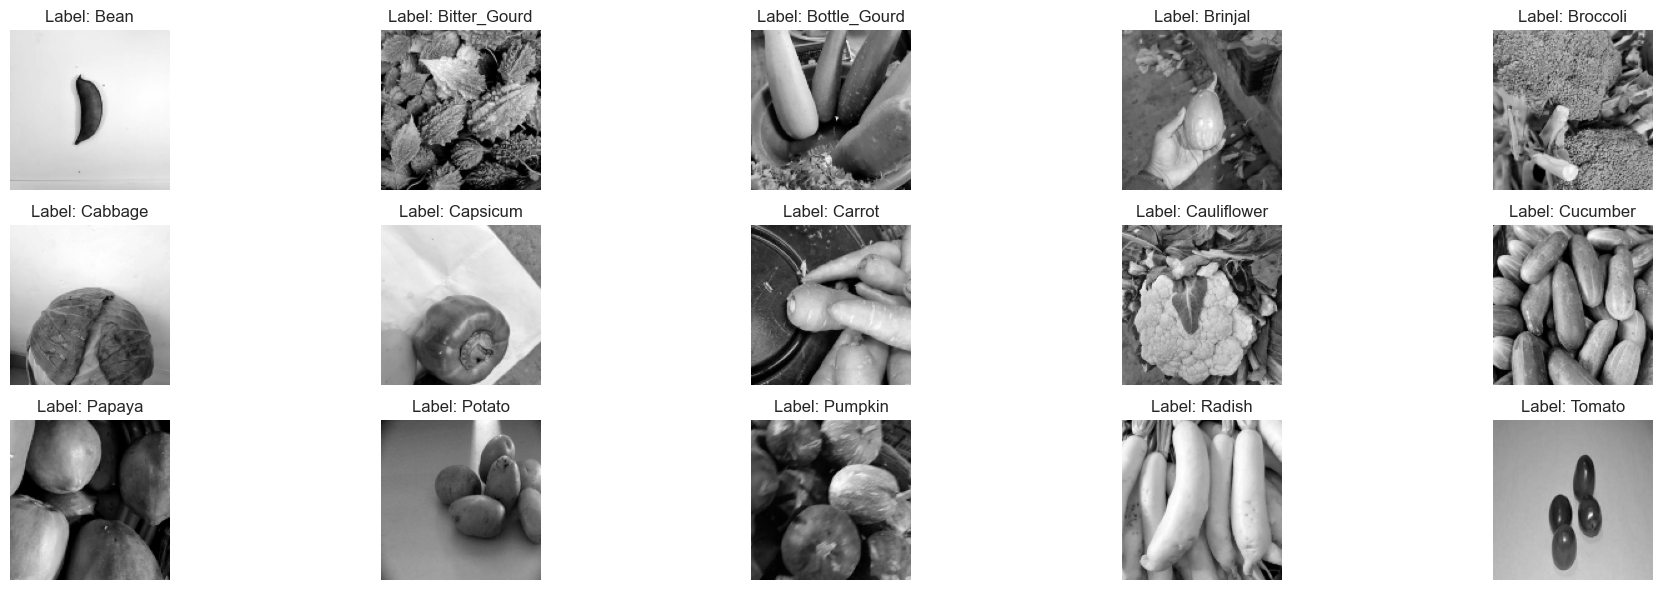

In [38]:
fig = plt.figure(figsize=(20, 6))

# Iterate through unique labels
for i, label in enumerate(np.unique(y_train), start=1):
    # Find the index of the first image with the current label
    index = np.where(y_train == label)[0][0]
    
    # Add a subplot for each label
    ax = fig.add_subplot(3, 5, i)  # You might need to adjust the subplot layout based on the number of unique labels
    
    # Display the image
    ax.imshow(X_train[index], cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Final Dataset observations:

Through the checks, we can see that the image was imported correctly. There are no glitched pixels, all of the pixels are within 0 and 255 (the shape of X_train is 128 by 128, if they were colored it would be 128 by 128 by 3)

## 3. Data Preprocessing/Feature Engineering

Firstly, I will be normalising the pixel values such that they range from 0 - 1 instead of 0 - 255. This is because it makes the machine more efficent when the range of numbers are smaller, due to the features being on a similar scale. If we do not do so, the network learns weights from features that are from different scales, and the large feature may 'drown' out the small features. Not rescaling the pixels can introduce the problem of exploding gradients, due to the high range of pixels.

The CNN model also requires 3D input, which means that the values need to be reshaped to 128x128x1.

#### 3a) Transforming x and y values / Reshaping 

In [39]:
# Using util function to firstly label encode, then use to_categorical to assign one hot encoding through
# binary vectors. Next, reshape 

(X_train, y_train), (X_test, y_test), (X_val, y_val) = preprocess((X_train, y_train), (X_test, y_test), (X_val, y_val))

#### 3b) Data augmentation

Data augmentation is a method to reduce the variance of a model by imposing random transformations on the data for training. Data augmentation is a method to reduce the variance of a model by imposing random transformations on the data for training. Some types of data augmentation include:

- Flipping
- Cropping
- Rotating
- Scaling
- Shearing

For this task, I will be using rotation, horizontal flip, and zoom. From the visualisation of the dataset earlier, we observed that there are a lot of variations in all the types of vegetables. It includes pictures from different angles, at different sizes as well as of different orientations. I feel that these are the most prominent types of "distortions" in the photo. Therefore, these are the ways that I chose the types of augmentation that I am applying.

I will also be setting the batch size to 64. I feel that this is a good value as I am able to trade a little bit of accuracy and risk slight overfitting for a better run time, which allows me to judge the model's performance better.

In [40]:
batch_size = 64

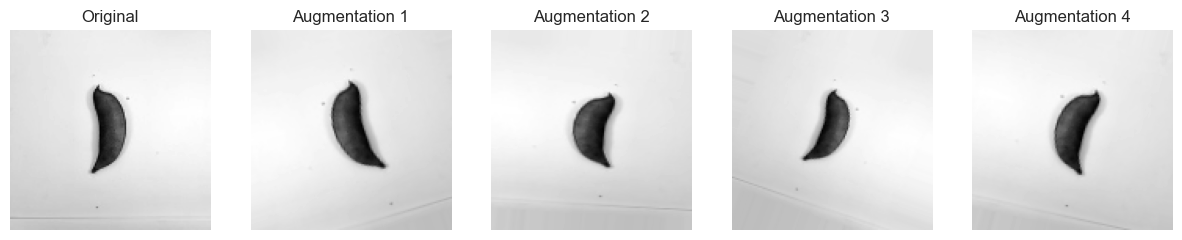

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
)

# Visualize the original and augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original image
axes[0].imshow(X_train[0].reshape(128, 128), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Augmented images
for i in range(1, 5):
    augmented_image = datagen.random_transform(X_train[0])  # Apply random transformations
    axes[i].imshow(augmented_image.reshape(128, 128), cmap='gray')
    axes[i].set_title(f'Augmentation {i}')
    axes[i].axis('off')

plt.show() 

## 4) Baseline Modelling

### Implementing a baseline CNN

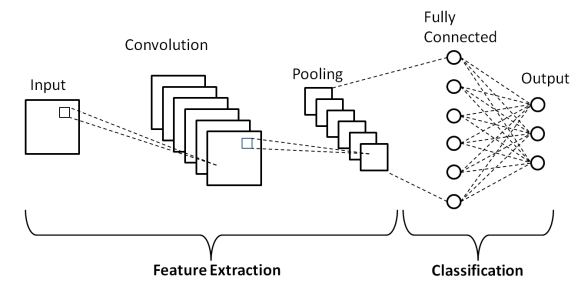

Generally, this is what a Convolutional Neural Network(CNN) looks like. 

In this portion of the task, I will be going through step by step on how I will be building my CNN, by explaining each layer as well as the different functions I will use to build the model.

<h4> Input Layer </h4>
This is where the image starts being processed. In the neural network of image processing, it generally represents the pixel matrix of the image.

<h4> Convolution Layer </h4>

<center> 
<img src = "Images/ConvolutionalLayer.gif" width="35%" height="35%"> 
<hr>
An animation on how the convolutional layer extract the various features from the input.
</center>


Convolutional layers are the core building blocks of CNNs. They apply convolutional operations to the input data, which helps in learning spatial hierarchies of features. By sliding the filter over the input image, the dot product is taken between the filter and the parts of the input image with respect to the size of the filter.

<h4> Activation Layer </h4>

Activation functions introduce non-linearity into the model, enabling it to learn complex relationships in the data. In a neural network without activation functions, the output of each layer is a linear combination of its inputs. Mathematically, if 
x is the input to a layer, and  W is the weight matrix, and b is the bias vector, the output y is given by:

<center>
y = Wx + b
</center>

However, with the introductions of activation functions, it determines the output of a neuron based on its input, and this non-linear transformation enables the model to learn and represent intricate patterns, capturing features like edges, textures, and more abstract concepts. Some of the more common activation functions include: ReLU, Sigmoid, Tanh (Hyperbolic Tangent), Softmax. These are the different functions of the various functions:

>ReLU
$$ 
f(x) = max(0, x)
$$
This takes all the negative values in the tensor and replaces them with 0. It has a unique problem called the "dying relu", where neurons become inactive and stop learning.


>Sigmoid
$$
f(x) = \frac{1}{1 + e^{-x}}
$$
Sigmoid squashes input values to the range of [0, 1]. It is commonly used in the output layer of binary classification models to produce probabilities. The output can be interpreted as the probability of belonging to the positive class.
>TanH
$$
f(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$
Tanh is similar to the sigmoid but squashes input values to the range of [-1, 1]. Like the sigmoid, it is often used in hidden layers of neural networks to introduce non-linearity.

>Softmax
$$
f(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$
Softmax is used in the output layer for multi-class classification problems. It converts the raw output values into a probability distribution over multiple classes. Each output is the exponentiated value of the corresponding input divided by the sum of all exponentiated values.

<h4> Pooling Layer </h4>

<h4> Fully Connected Layer </h4>

<h4> Batch normalization </h4>

Batch Norm reduces the amount of shifts of distribution for hidden unit values, no matter how the values from previous unit shifts. Batch normalisation is scaled by the mean/variance of the mini-batch, which adds some noise to the values 
; thus having some regularization effect.

<h4> Dropout Layer </h4>

In [52]:
input_shape = (128, 128, 1)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

# Plot training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
_, test_accuracy = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/100
142/142 [==============================] - 14s 87ms/step - loss: 2.1557 - accuracy: 0.3188 - val_loss: 1.8035 - val_accuracy: 0.4290
Epoch 2/100
142/142 [==============================] - 9s 63ms/step - loss: 1.3245 - accuracy: 0.5852 - val_loss: 1.4148 - val_accuracy: 0.5667
Epoch 3/100
142/142 [==============================] - 9s 63ms/step - loss: 0.8862 - accuracy: 0.7291 - val_loss: 1.0701 - val_accuracy: 0.6830
Epoch 4/100
142/142 [==============================] - 9s 63ms/step - loss: 0.5452 - accuracy: 0.8384 - val_loss: 1.0186 - val_accuracy: 0.6987
Epoch 5/100
142/142 [==============================] - 9s 64ms/step - loss: 0.3725 - accuracy: 0.8943 - val_loss: 1.0985 - val_accuracy: 0.7023
Epoch 6/100
142/142 [==============================] - 9s 62ms/step - loss: 0.2167 - accuracy: 0.9415 - val_loss: 1.1013 - val_accuracy: 0.7190
Epoch 7/100
142/142 [==============================] - 9s 64ms/step - loss: 0.1255 - accuracy: 0.9718 - val_loss: 1.1416 - val_accuracy

## Model Improvement

<hr>

# References

Dataset: <br>
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset <br>

Sources: <br>
https://www.upgrad.com/blog/basic-cnn-architecture/ <br>
https://datagen.tech/guides/computer-vision/cnn-convolutional-neural-network/#:~:text=Deep%20learning%20applications%20often%20use,and%20produce%20highly%20accurate%20predictions.<br>
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8<br>
https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/<br>
https://medium.com/@draj0718/convolutional-neural-networks-cnn-architectures-explained-716fb197b243<br>